# Explotation of proteomics data

The aim of this exercise is to sort samples by exposure. The main task here is to find discriminating features. This is what machine learning is about. 

In [1]:
# First we load some libraries that we always need
# If you do not know what they are good for I suggest 
# three options:
# 1. Do not worry about this for now
# 2. Use google to find information
# 3. Ask somebody who might know
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First we load the file containing the data.

In [2]:
# Read in the excel file
filepath = '../rawdata/In_vivo_I_proteomics/Proteomikk_IV1_FC.xlsx'
df = pd.read_excel(io=filepath, index_col=2, header=[0])

In [3]:
# Clear up column names
df = df.rename(columns={'Unnamed: 0': 'dose', 'Unnamed: 1': 'Gender'})
df = df.drop(df.index[0])

If you want to, you can inspect the content of the resulting DataFrame `df`. Since it clutters your screen I have commented the following cell out. You can activate it by seclecting it and changing its type to code. One way to do this is through the "Cell" option  on the top of this page.

We are going to work with the doses, so we extract them from the dataframe.

In [4]:
doses = df['dose'].values

Next we flip (transpose) the dataframe (spreadsheet) and discard all gene ids with empty entries.

In [5]:
df = df.transpose()
df = df.dropna()

### Magic data manipulation. 

We first compute the first 5 principal directions of the gene ids with respect to the samples grouped into dosage. Then we use these principal directions to project the individual samples to 5 dimensional space. We store the result in the variable `X`.

We perform the magic arcsinh transform to the data. This is similar to log transforming the data. It has the advantage that it tolorates zero values.

In [6]:
df[df.columns].iloc[2:] = np.arcsinh(df[df.columns].iloc[2:].astype(float) / 5)

We take average of gene expressions for each exposure group.

In [7]:
# Construct auxillary dataframes holding the flipped and averaged expressions
df2 = df.iloc[2:].astype(float).transpose()
df2['doses'] = doses
df2groups = df2.groupby('doses')
# Extract the averaged expressions in a numpy array
fit_values = df2groups.mean().values
# Clean up by deleting the auxillary dataframes
del df2
del df2groups

Finally we reduce dimensionality by principal components. We use as many principal components as the data supports. There is a trick here. The mean values over exposures are used to find principal components but the individual samples are transformed by these principal components. This way we have learned something about the effect of the different exposures.

In [8]:
# Import PCA module
from sklearn.decomposition import PCA
# Fit and transform PCA
pca = PCA(n_components=min(fit_values.shape)).fit(fit_values)
print('explained_variance_ratio', np.cumsum(pca.explained_variance_ratio_))
X = pca.transform(df.iloc[2:].astype(float).values.transpose())

explained_variance_ratio [0.49796158 0.61502442 0.69812662 0.7719907  0.84005761 0.89872797
 0.95431074 1.         1.        ]


### Visualization

We define a helper function for plotting. It takes several inputs.
* X is two-dimensional data that will be plotted by placing abbreviated dose names in the appropritat position on the plane
* y_text holds the dose abbreviations
* y_color specifies the colors. To begin with we want text and color to correspond.
* outlieres is set to true when clustering with outliers is to be visualized

In [9]:
from itertools import cycle, islice
def plot_embedding(X, y_text, y_color=None, title=None, colors=None, outliers=False):
    if y_color is None:
        y_color = y_text
    if colors is None:
        palette = np.vstack((plt.cm.tab10(np.arange(10)), plt.cm.Set3(np.arange(12))))
        palette = np.array(list(islice(cycle(palette), len(np.unique(y_color)))))
        if outliers:
            palette = np.vstack(([0,0,0,1], palette))
        colors = {}
        for idx, value in enumerate(np.unique(y_color)):
            colors[value] = palette[idx]
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    dimensions = x_max - x_min
    x_max = x_max + 0.1*dimensions
    x_min = x_min - 0.05*dimensions

    #plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_text[i]),
                 color=colors[y_color[i]],
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

### Plot the data

First we plot the first two principal components

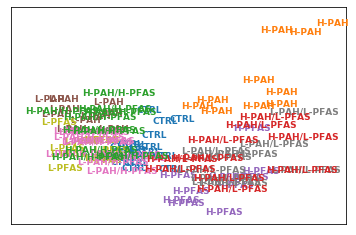

In [10]:
plot_embedding(X[:, [0, 1]], 
               df.loc['dose'].values, 
               y_color=df.loc['dose'].values, colors=None)

And the second and third principal components

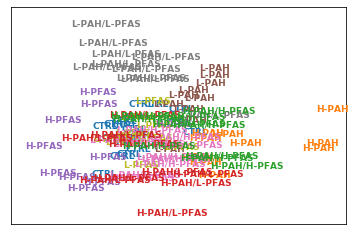

In [11]:
plot_embedding(X[:, [1, 2]], 
               df.loc['dose'].values, 
               y_color=df.loc['dose'].values, colors=None)

Next we compute a fancy embedding of the all principal components.

In [12]:
# Import UMAP module
from umap import UMAP
# Suppress annoying warnings
import warnings
warnings.filterwarnings('ignore')
Y = UMAP(n_components=2).fit_transform(X)

And plot it

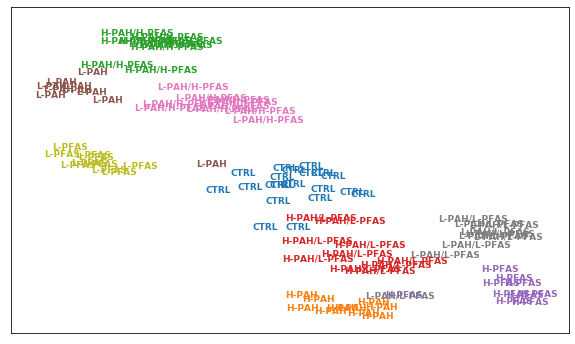

In [13]:
plt.figure(figsize=(10,6))
plot_embedding(Y, 
               df.loc['dose'].values, 
               y_color=df.loc['dose'].values,
               colors=None)

Congratulations! Your data reflects the different exposures.

### Clustering

Now that we know that the data reflects the exposures we might appempt to automatically sort the data into exposure gorups. This is what clustering algorithms do for us. We use one of the more recent algorithms called hdbscan.

In [14]:
import hdbscan

Instead of using the two-dimensional imbedding `Y` to form clusters we produce a new embedding `Z` of dimension as high as the data allows.

In [15]:
Z = UMAP(n_components=min(X.shape)).fit_transform(X)

Here some trail and error has been invested to find suitable parameters. 

In [16]:
clusterer = hdbscan.HDBSCAN()

In [17]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=1)

We compute the cluster labels of the samples and store them in a variable called `cluster_labels'

In [18]:
cluster_labels = clusterer.fit_predict(Z)

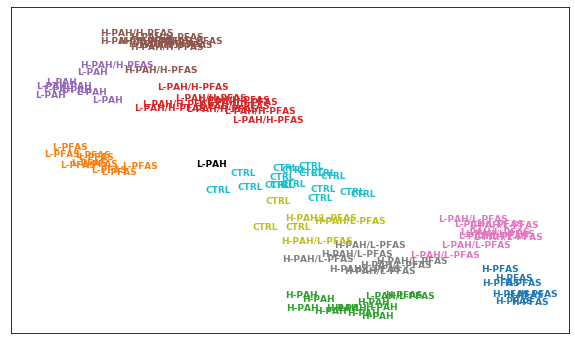

In [19]:
plt.figure(figsize=(10,6))
plot_embedding(Y, 
               df.loc['dose'].values, 
               y_color=cluster_labels,
               outliers=True,
               colors=None)

Now we need a statistician to tell us how good these clusters are. Or maybe just different colors?

In [20]:
print(list(zip(cluster_labels, doses)))

[(9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (8, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (8, 'CTRL'), (8, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (9, 'CTRL'), (-1, 'L-PAH'), (4, 'L-PAH'), (4, 'L-PAH'), (4, 'L-PAH'), (4, 'L-PAH'), (4, 'L-PAH'), (4, 'L-PAH'), (4, 'L-PAH'), (4, 'L-PAH'), (4, 'L-PAH'), (2, 'H-PAH'), (2, 'H-PAH'), (2, 'H-PAH'), (2, 'H-PAH'), (2, 'H-PAH'), (2, 'H-PAH'), (2, 'H-PAH'), (2, 'H-PAH'), (2, 'H-PAH'), (2, 'H-PAH'), (1, 'L-PFAS'), (1, 'L-PFAS'), (1, 'L-PFAS'), (1, 'L-PFAS'), (1, 'L-PFAS'), (1, 'L-PFAS'), (1, 'L-PFAS'), (1, 'L-PFAS'), (1, 'L-PFAS'), (1, 'L-PFAS'), (0, 'H-PFAS'), (0, 'H-PFAS'), (0, 'H-PFAS'), (0, 'H-PFAS'), (0, 'H-PFAS'), (0, 'H-PFAS'), (0, 'H-PFAS'), (0, 'H-PFAS'), (2, 'H-PFAS'), (0, 'H-PFAS'), (6, 'L-PAH/L-PFAS'), (6, 'L-PAH/L-PFAS'), (6, 'L-PAH/L-PFAS'), (6, 'L-PAH/L-PFAS'), (6, 'L-PAH/L-PFAS'), (6, 'L-PAH/L-PFAS'), (6, 'L-PAH/L-PFAS'), (6, 'L-PAH/